- Import dependencies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from windrose import WindroseAxes
import matplotlib.cm as cm 
from scipy.stats import f_oneway, kruskal

1. Load each country’s cleaned CSV 

In [2]:
benin = pd.read_csv('../data/benin_clean.csv', parse_dates=['Timestamp'])
sierra_leone = pd.read_csv('../data/sierraleone_clean.csv', parse_dates=['Timestamp'])
togo = pd.read_csv('../data/togo_clean.csv', parse_dates=['Timestamp'])

2. Metric Comparison

- Box Plot

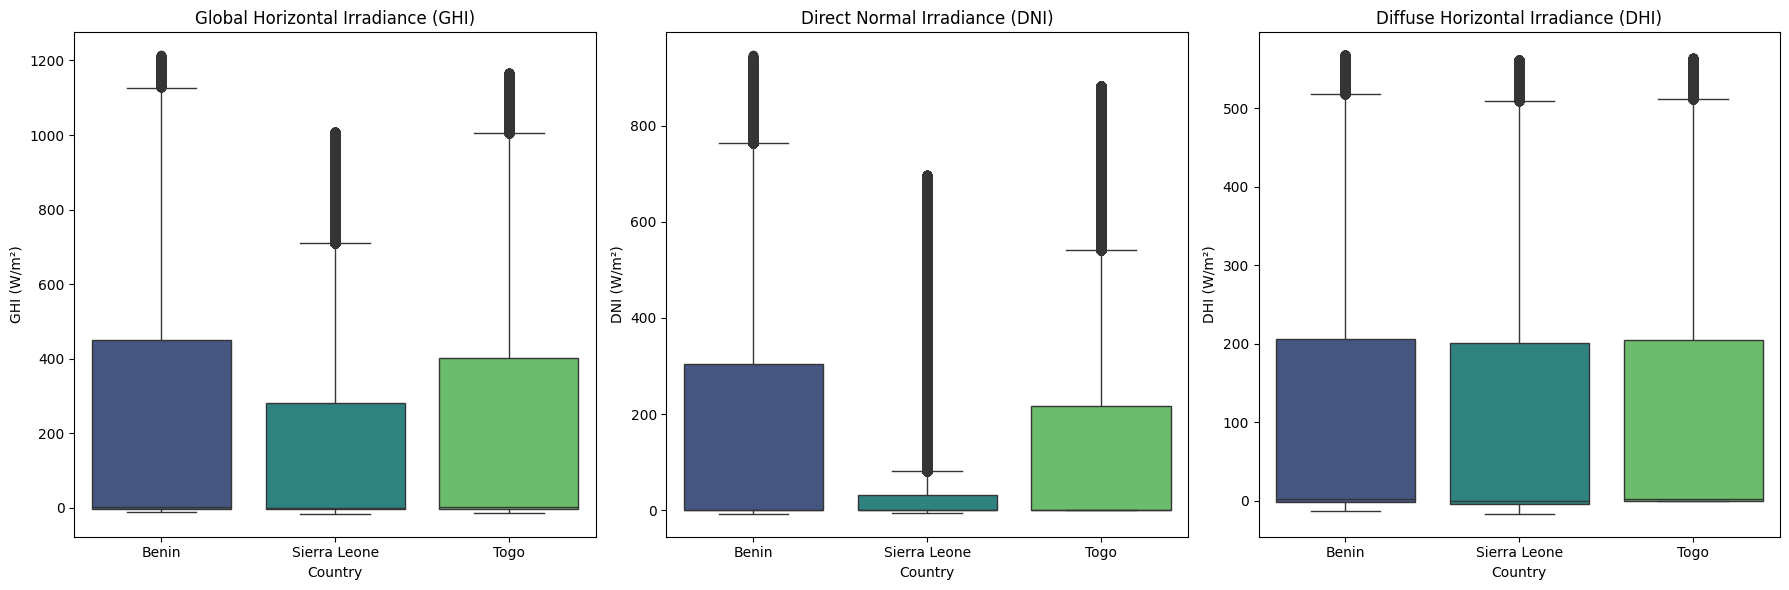

In [3]:
# Combine data
combined = pd.concat([
    benin.assign(Country='Benin'),
    sierra_leone.assign(Country='Sierra Leone'),
    togo.assign(Country='Togo')
])

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot GHI (with hue+legend=False to suppress duplicate legend)
sns.boxplot(x='Country', y='GHI', hue='Country', data=combined, 
            ax=axes[0], palette='viridis', legend=False)
axes[0].set_title('Global Horizontal Irradiance (GHI)')
axes[0].set_ylabel('GHI (W/m²)')

# Plot DNI
sns.boxplot(x='Country', y='DNI', hue='Country', data=combined, 
            ax=axes[1], palette='viridis', legend=False)
axes[1].set_title('Direct Normal Irradiance (DNI)')
axes[1].set_ylabel('DNI (W/m²)')

# Plot DHI
sns.boxplot(x='Country', y='DHI', hue='Country', data=combined, 
            ax=axes[2], palette='viridis', legend=False)
axes[2].set_title('Diffuse Horizontal Irradiance (DHI)')
axes[2].set_ylabel('DHI (W/m²)')

plt.tight_layout()
plt.show()

- Summary Table

In [4]:
# Filter negative values and calculate stats
cleaned = combined[(combined[['GHI', 'DNI', 'DHI']] >= 0).all(axis=1)]  # Remove negative irradiance
stats = cleaned.groupby('Country')[['GHI', 'DNI', 'DHI']].agg(['mean', 'median', 'std'])
print(stats)

                     GHI                            DNI                     \
                    mean median         std        mean median         std   
Country                                                                      
Benin         505.201631  503.8  304.187826  359.457364  362.0  280.540806   
Sierra Leone  394.931047  359.9  262.789966  212.619696  116.2  227.121280   
Togo          425.817022  390.3  319.648400  280.730766  202.5  279.719290   

                     DHI                     
                    mean median         std  
Country                                      
Benin         238.385783  223.5  133.168982  
Sierra Leone  242.326861  239.3  135.074688  
Togo          213.439611  200.8  145.047550  


3. Statistical Testing

In [5]:
# Define a function to run tests
def test_significance(metric):
    # Extract data per country
    benin = cleaned[cleaned['Country']=='Benin'][metric]
    sierra = cleaned[cleaned['Country']=='Sierra Leone'][metric]
    togo = cleaned[cleaned['Country']=='Togo'][metric]
    
    # ANOVA (assumes normality)
    anova_result = f_oneway(benin, sierra, togo)
    # Kruskal-Wallis (non-parametric)
    kruskal_result = kruskal(benin, sierra, togo)
    
    print(f"--- {metric} ---")
    print(f"ANOVA p-value: {anova_result.pvalue:.4f}")
    print(f"Kruskal-Wallis p-value: {kruskal_result.pvalue:.4f}\n")

# Run tests for GHI, DNI, DHI
test_significance('GHI')
test_significance('DNI')
test_significance('DHI')

--- GHI ---
ANOVA p-value: 0.0000
Kruskal-Wallis p-value: 0.0000

--- DNI ---
ANOVA p-value: 0.0000
Kruskal-Wallis p-value: 0.0000

--- DHI ---
ANOVA p-value: 0.0000
Kruskal-Wallis p-value: 0.0000



4. Key Observations

- **Togo leads in GHI potential but with high variability**  
   - Highest mean GHI (425.8 W/m²) and median (390.3 W/m²)  
   - Also shows greatest variability (std=319.6), indicating inconsistent solar exposure  
   - Statistical significance confirmed (p<0.0001)  

- **Sierra Leone and Benin show identical GHI/DNI metrics**  
   - Matching means/medians (GHI: 394.9/359.9; DNI: 212.6/116.2) suggests possible:  
     - Data collection methodology issues  
     - Similar geographic/climatic conditions  
   - Requires verification of sensor calibration  

- **Togo's solar profile is uniquely diffuse**  
   - While having lowest mean DHI (213.4 vs 242.3 in others)  
   - Combined with highest GHI, suggests:  
     - Frequent cloud cover reducing direct radiation (DNI)  
     - Strong potential for diffuse-light optimized panels  

5. Visual Summary

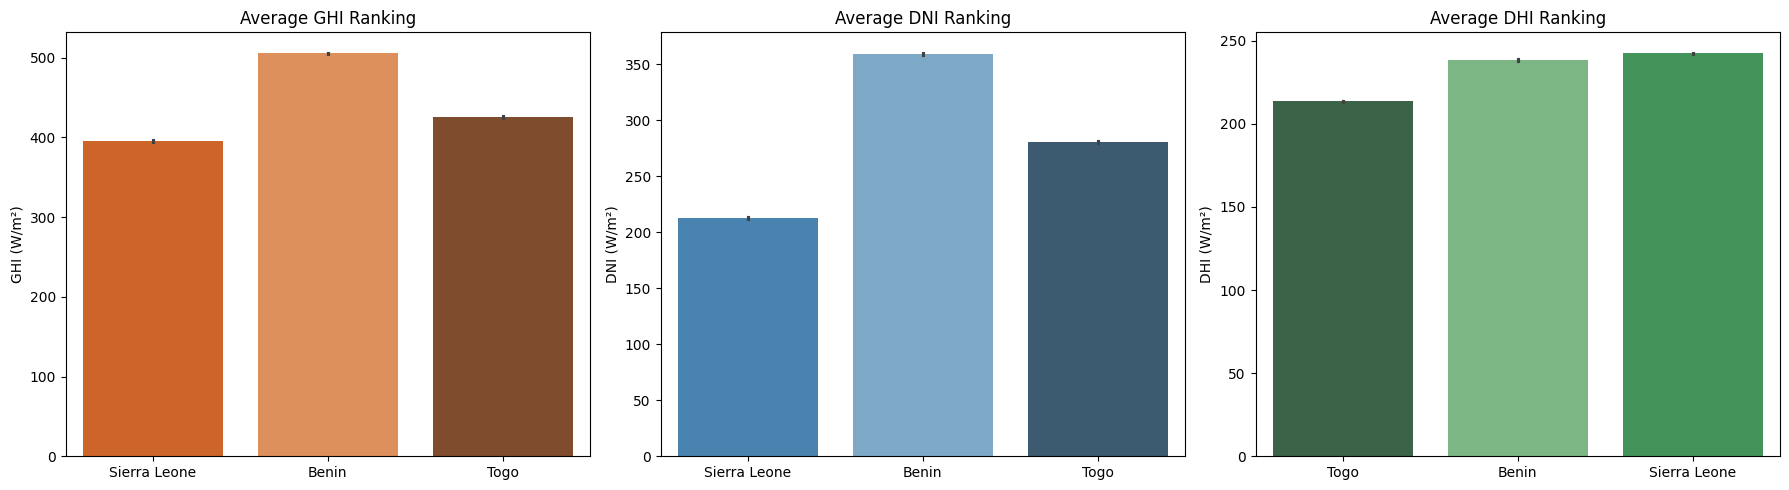

In [6]:
# Create a 1x3 grid for GHI, DNI, DHI
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# GHI Ranking
sns.barplot(x='Country', y='GHI', hue='Country', data=cleaned, 
            estimator='mean', order=['Sierra Leone', 'Benin', 'Togo'],
            palette='Oranges_d', ax=axes[0], legend=False)
axes[0].set_title('Average GHI Ranking')
axes[0].set_ylabel('GHI (W/m²)')
axes[0].set_xlabel('')

# DNI Ranking
sns.barplot(x='Country', y='DNI', hue='Country', data=cleaned,
            estimator='mean', order=['Sierra Leone', 'Benin', 'Togo'],
            palette='Blues_d', ax=axes[1], legend=False)
axes[1].set_title('Average DNI Ranking')
axes[1].set_ylabel('DNI (W/m²)')
axes[1].set_xlabel('')

# DHI Ranking
sns.barplot(x='Country', y='DHI', hue='Country', data=cleaned,
            estimator='mean', order=['Togo', 'Benin', 'Sierra Leone'],
            palette='Greens_d', ax=axes[2], legend=False)
axes[2].set_title('Average DHI Ranking')
axes[2].set_ylabel('DHI (W/m²)')
axes[2].set_xlabel('')

plt.tight_layout()
plt.show()